Lets begin

In [37]:
from pre_processing import read_jsons, read_exercise
from helper import extract_credits, extract_ids
ex_num = 6348 # 6347 was interesting , 41604 wtf


In [38]:
def handle_missing_submission_id_credits(data, models):
    # Iterate through all expected submission IDs and check if they exist in the data
    for submission_id in data.keys():
        for model in models:
            if model not in data[submission_id].keys():
                print(f"Missing model: {model}. Using 0 as default.")
                data[submission_id][model] = 0

    return data
def handle_missing_submission_id_instructions(data, models):
    # Iterate through all expected submission IDs and check if they exist in the data
    for submission_id in data.keys():
        for model in models:
            if model not in data[submission_id].keys():
                print(f"Missing model: {model}. Using [] as default.")
                data[submission_id][model] = []

    return data

In [39]:
directory_approaches = f"{ex_num}"
exercise_path = f"{ex_num}/exercise"

llm_data,models = read_jsons(directory_approaches)
tutor_data, max_credit, submission_ids = read_exercise(exercise_path ,list(llm_data.keys()))

# # TOOO Extract the max points and the instructions from the exercise data
ex_Credits = extract_credits(tutor_data,llm_data)
ex_ids = extract_ids(tutor_data,llm_data)
# print(ex_Credits)
ex_Credits = handle_missing_submission_id_credits(ex_Credits,models)
ex_ids = handle_missing_submission_id_instructions(ex_ids,models)

### **Jaccard Similarity**

**Definition**:  
Jaccard Similarity measures the proportion of overlap between two sets. It is defined as the size of the intersection divided by the size of the union:

$$
\text{Jaccard Similarity} = \frac{|A \cap B|}{|A \cup B|}
$$

**Why Use It?**  
- It is ideal for comparing the **presence or absence** of items, regardless of frequency.  
- Highlights unique elements in each set.  
- Useful for evaluating how many instruction IDs are shared between a tutor and a model.

**Limitations**:  
- Ignores **frequency**, so it does not capture proportional differences in usage.

---

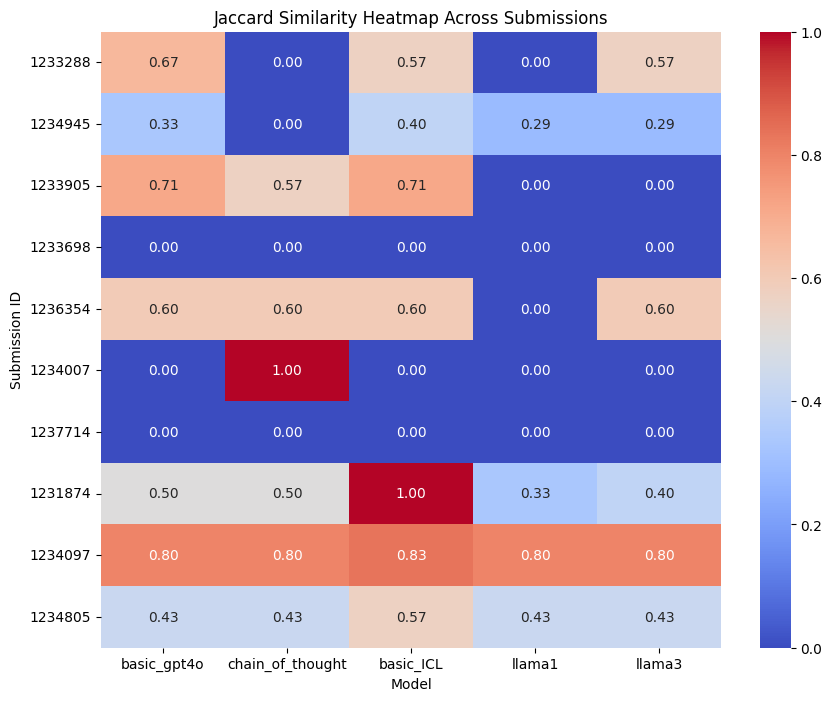

In [40]:
from collections import Counter
from sklearn.metrics import jaccard_score
import numpy as np
data = ex_ids
results = {}

for submission_id, sources in data.items():
    tutor_ids = Counter(sources['tutor'])
    submission_results = {}
    
    for model, model_ids in sources.items():
        if model == 'tutor':
            continue
        
        model_ids_counter = Counter(model_ids)
        
        # Exact Matches
        exact_matches = sum((tutor_ids & model_ids_counter).values())
        
        # Unique Differences
        tutor_unique = list((tutor_ids - model_ids_counter).elements())
        model_unique = list((model_ids_counter - tutor_ids).elements())
        
        # Jaccard Similarity
        tutor_set = set(sources['tutor'])
        model_set = set(model_ids)
        if(len(tutor_set | model_set) == 0):
            jaccard_similarity = 0
        else:
            jaccard_similarity = len(tutor_set & model_set) / len(tutor_set | model_set)
        
        # Record Results
        submission_results[model] = {
            "exact_matches": exact_matches,
            "tutor_unique": tutor_unique,
            "model_unique": model_unique,
            "jaccard_similarity": jaccard_similarity,
        }
    
    results[submission_id] = submission_results

# Print results
# for submission_id, submission_results in results.items():
#     print(f"Submission ID: {submission_id}")
#     for model, metrics in submission_results.items():
#         print(f"  Model: {model}")
#         print(f"    Exact Matches: {metrics['exact_matches']}")
#         print(f"    Tutor Unique: {metrics['tutor_unique']}")
#         print(f"    Model Unique: {metrics['model_unique']}")
#         print(f"    Jaccard Similarity: {metrics['jaccard_similarity']:.2f}")
        
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
models = set(model for sub_results in results.values() for model in sub_results.keys())
submission_ids = list(results.keys())
# Prepare data for heatmap
heatmap_data = pd.DataFrame({
    model: [results[submission_id][model]["jaccard_similarity"] for submission_id in submission_ids]
    for model in models if model != 'tutor'
}, index=submission_ids)

# Heatmap for Jaccard Similarity
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Jaccard Similarity Heatmap Across Submissions')
plt.xlabel('Model')
plt.ylabel('Submission ID')
plt.show()

### **Cosine Similarity**

**Definition**:  
Cosine Similarity measures the cosine of the angle between two frequency vectors, capturing how similar their direction is:

$$
\text{Cosine Similarity} = \frac{\sum{(A_i \cdot B_i)}}{\sqrt{\sum{A_i^2}} \cdot \sqrt{\sum{B_i^2}}}
$$

**Why Use It?**  
- It considers **frequency**, making it ideal for proportional comparisons.  
- Highlights how closely the model replicates the tutor's instruction usage.  
- Useful for evaluating differences in **usage patterns** between a tutor and a model.

**Limitations**:  
- Does not focus solely on shared items; low-frequency instructions may dilute the score.

Submission ID: 1233288
  Model: basic_gpt4o
    Cosine Similarity: 0.93
  Model: basic_ICL
    Cosine Similarity: 0.90
  Model: chain_of_thought
    Cosine Similarity: 0.00
  Model: llama1
    Cosine Similarity: 0.00
  Model: llama3
    Cosine Similarity: 0.86
Submission ID: 1234945
  Model: basic_gpt4o
    Cosine Similarity: 0.42
  Model: basic_ICL
    Cosine Similarity: 0.46
  Model: chain_of_thought
    Cosine Similarity: 0.00
  Model: llama1
    Cosine Similarity: 0.40
  Model: llama3
    Cosine Similarity: 0.40
Submission ID: 1233905
  Model: basic_gpt4o
    Cosine Similarity: 0.80
  Model: basic_ICL
    Cosine Similarity: 0.80
  Model: chain_of_thought
    Cosine Similarity: 0.77
  Model: llama1
    Cosine Similarity: 0.00
  Model: llama3
    Cosine Similarity: 0.00
Submission ID: 1233698
  Model: basic_gpt4o
    Cosine Similarity: 0.00
  Model: basic_ICL
    Cosine Similarity: 0.00
  Model: chain_of_thought
    Cosine Similarity: 0.00
  Model: llama1
    Cosine Similarity: 0.00


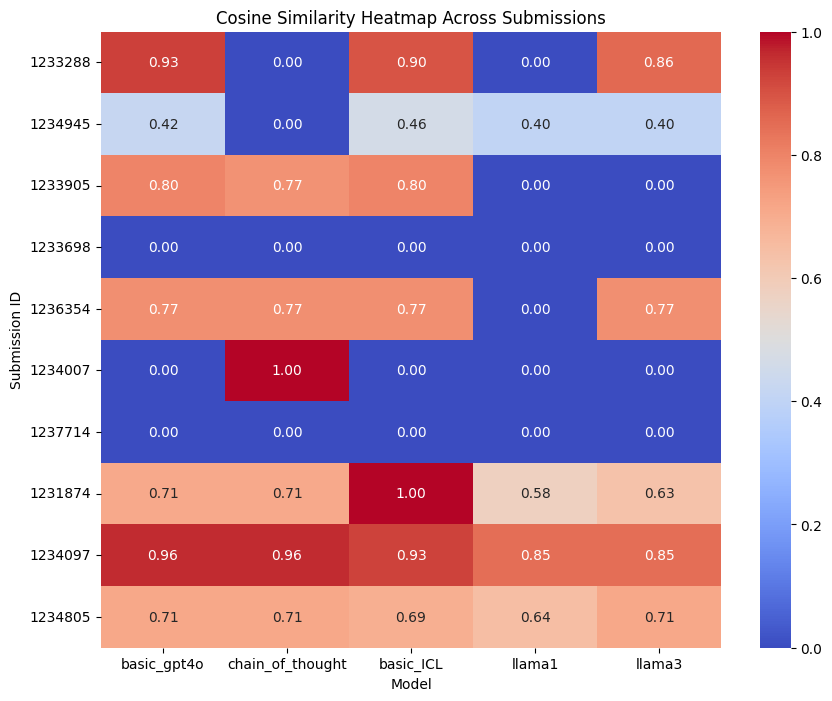

In [41]:
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
data = ex_ids
results = {}

for submission_id, sources in data.items():
    tutor_counter = Counter(sources['tutor'])
    all_ids = set(tutor_counter.keys())
    
    # Collect all unique instruction IDs for a consistent vector size
    for model in sources.keys():
        all_ids.update(sources[model])

    all_ids = sorted(all_ids)  # Ensure consistent ordering
    submission_results = {}
    
    for model, model_ids in sources.items():
        if model == 'tutor':
            continue
        
        # Create frequency vectors
        model_counter = Counter(model_ids)
        tutor_vector = np.array([tutor_counter[id_] for id_ in all_ids])
        model_vector = np.array([model_counter[id_] for id_ in all_ids])
        
        # Cosine Similarity
        cosine_sim = cosine_similarity([tutor_vector], [model_vector])[0, 0]
        
        # Exact Matches (intersection based on frequency)
        exact_matches = sum(min(tutor_counter[id_], model_counter[id_]) for id_ in all_ids)
        
        # Unique Differences
        tutor_unique = [(id_, tutor_counter[id_]) for id_ in all_ids if tutor_counter[id_] > model_counter[id_]]
        model_unique = [(id_, model_counter[id_]) for id_ in all_ids if model_counter[id_] > tutor_counter[id_]]
        
        # Record Results
        submission_results[model] = {
            "cosine_similarity": cosine_sim,
            "exact_matches": exact_matches,
            "tutor_unique": tutor_unique,
            "model_unique": model_unique,
        }
    
    results[submission_id] = submission_results

# Print results
for submission_id, submission_results in results.items():
    print(f"Submission ID: {submission_id}")
    for model, metrics in submission_results.items():
        print(f"  Model: {model}")
        print(f"    Cosine Similarity: {metrics['cosine_similarity']:.2f}")
        # print(f"    Exact Matches: {metrics['exact_matches']}")
        # print(f"    Tutor Unique: {metrics['tutor_unique']}")
        # print(f"    Model Unique: {metrics['model_unique']}")
        
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for heatmap
heatmap_data = pd.DataFrame({
    model: [results[submission_id][model]["cosine_similarity"] for submission_id in submission_ids]
    for model in models if model != 'tutor'
}, index=submission_ids)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cosine Similarity Heatmap Across Submissions')
plt.xlabel('Model')
plt.ylabel('Submission ID')
plt.show()

In [42]:
from itertools import combinations
import numpy as np

def calculate_self_consistency(data, metric="cosine"):
    """
    Calculate self-consistency among models by comparing their instruction usage patterns.

    Parameters:
        data (dict): The dictionary where each submission ID maps to model instruction IDs.
        metric (str): The similarity metric to use, "jaccard" or "cosine".

    Returns:
        dict: A dictionary with average similarity scores for each model.
    """
    def jaccard_similarity(set1, set2):
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        return intersection / union if union > 0 else 0.0

    def cosine_similarity(vec1, vec2):
        dot_product = sum(a * b for a, b in zip(vec1, vec2))
        norm1 = np.sqrt(sum(a ** 2 for a in vec1))
        norm2 = np.sqrt(sum(b ** 2 for b in vec2))
        return dot_product / (norm1 * norm2) if norm1 > 0 and norm2 > 0 else 0.0

    # Initialize scores for each model
    model_scores = {model: [] for model in next(iter(data.values())).keys()}

    # Iterate over all submission IDs
    for submission_id, models in data.items():
        model_names = list(models.keys())
        pairs = combinations(model_names, 2)

        # Compare each pair of models
        for model1, model2 in pairs:
            if metric == "jaccard":
                similarity = jaccard_similarity(set(models[model1]), set(models[model2]))
            elif metric == "cosine":
                similarity = cosine_similarity(
                    np.bincount(models[model1]),
                    np.bincount(models[model2])
                )
            else:
                raise ValueError("Unsupported metric. Use 'jaccard' or 'cosine'.")
            
            model_scores[model1].append(similarity)
            model_scores[model2].append(similarity)

    # Calculate average similarity for each model
    avg_scores = {model: np.mean(scores) for model, scores in model_scores.items()}
    return avg_scores

# result = calculate_self_consistency(ex_ids, metric="jaccard")
# print(result)
# result = calculate_self_consistency(ex_ids, metric="cosine")
# print(result)
result_jaccard = calculate_self_consistency(ex_ids, metric="jaccard")
result_cosine = calculate_self_consistency(ex_ids, metric="cosine")

# Sort the results in descending order (biggest value first)
sorted_result_jaccard = sorted(result_jaccard.items(), key=lambda x: x[1], reverse=True)
sorted_result_cosine = sorted(result_cosine.items(), key=lambda x: x[1], reverse=True)

# Print sorted results
print("Jaccard Similarity (Sorted by value):")
for model, value in sorted_result_jaccard:
    print(f"{model}: {value:.2f}")

print("\nCosine Similarity (Sorted by value):")
for model, value in sorted_result_cosine:
    print(f"{model}: {value:.2f}")

Jaccard Similarity (Sorted by value):
basic_gpt4o: 0.50
basic_ICL: 0.43
llama3: 0.43
tutor: 0.35
llama1: 0.35
chain_of_thought: 0.35

Cosine Similarity (Sorted by value):
basic_gpt4o: 0.59
basic_ICL: 0.54
llama3: 0.52
tutor: 0.45
llama1: 0.42
chain_of_thought: 0.40


17.25
10.0
17.25
1.0
12.75
1.8333333333333333
1.3333333333333333
7.5
14.25
11.833333333333334
{'tutor': 16.5, 'basic_gpt4o': 18, 'basic_ICL': 20, 'chain_of_thought': 16, 'llama1': 20, 'llama3': 13}
{1233288: {'tutor': 16.5, 'basic_gpt4o': 18, 'basic_ICL': 20, 'chain_of_thought': 16, 'llama1': 20, 'llama3': 13, 'consistency': 18}, 1234945: {'tutor': 0.5, 'basic_gpt4o': 12, 'basic_ICL': 12, 'chain_of_thought': 6.5, 'llama1': 15, 'llama3': 14}, 1233905: {'tutor': 16.0, 'basic_gpt4o': 20, 'basic_ICL': 20, 'chain_of_thought': 18, 'llama1': 13.5, 'llama3': 16}, 1233698: {'tutor': 0, 'basic_gpt4o': 0, 'basic_ICL': 2, 'chain_of_thought': 1, 'llama1': 2.5, 'llama3': 0.5}, 1236354: {'tutor': 5, 'basic_gpt4o': 9.5, 'basic_ICL': 9.5, 'chain_of_thought': 9.5, 'llama1': 31, 'llama3': 12}, 1234007: {'tutor': 0, 'basic_gpt4o': 2, 'basic_ICL': 0, 'chain_of_thought': 0, 'llama1': 7, 'llama3': 2}, 1237714: {'tutor': 0, 'basic_gpt4o': 0, 'basic_ICL': 1, 'chain_of_thought': 0, 'llama1': 5.5, 'llama3': 1.5}

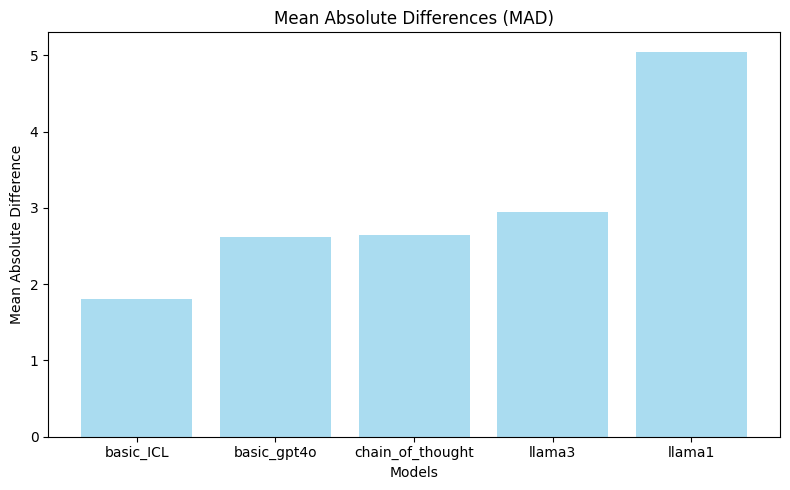

Mean Absolute Differences (MAD):
basic_ICL: 1.80
basic_gpt4o: 2.62
chain_of_thought: 2.65
llama3: 2.95
llama1: 5.05
{1233288: {'tutor': 16.5, 'basic_gpt4o': 18, 'basic_ICL': 20, 'chain_of_thought': 16, 'llama1': 20, 'llama3': 13, 'consistency': 18}, 1234945: {'tutor': 0.5, 'basic_gpt4o': 12, 'basic_ICL': 12, 'chain_of_thought': 6.5, 'llama1': 15, 'llama3': 14, 'consistency': 12}, 1233905: {'tutor': 16.0, 'basic_gpt4o': 20, 'basic_ICL': 20, 'chain_of_thought': 18, 'llama1': 13.5, 'llama3': 16, 'consistency': 18}, 1233698: {'tutor': 0, 'basic_gpt4o': 0, 'basic_ICL': 2, 'chain_of_thought': 1, 'llama1': 2.5, 'llama3': 0.5, 'consistency': 1}, 1236354: {'tutor': 5, 'basic_gpt4o': 9.5, 'basic_ICL': 9.5, 'chain_of_thought': 9.5, 'llama1': 31, 'llama3': 12, 'consistency': 12}, 1234007: {'tutor': 0, 'basic_gpt4o': 2, 'basic_ICL': 0, 'chain_of_thought': 0, 'llama1': 7, 'llama3': 2, 'consistency': 2}, 1237714: {'tutor': 0, 'basic_gpt4o': 0, 'basic_ICL': 1, 'chain_of_thought': 0, 'llama1': 5.5, 'll

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
data = ex_Credits

def evaluate_credits_from_mean(data):
    consistency_data = data.copy()
    """
    Evaluate and visualize model performance based on credit differences compared to the tutor.
    
    Parameters:
        data (dict): A dictionary where submission IDs map to credit values from the tutor and models.
    """
    models = set(next(iter(data.values())).keys()) - {'tutor', 'consistency'}
    diffs = {model: [] for model in models}
    
    # Calculate absolute differences
    for submission_id, credits in data.items():
        credit_count = []
        for source, credit in credits.items():
            credit_count.append(credit)
        # print(credits)
        tutor_score = np.mean(credit_count)
        print(tutor_score)
        #  = credits['tutor']
        for model in models:
            diffs[model].append(abs(credits[model] - tutor_score))
    
    # for model in models:
    #     print(diffs[model])
    # # Calculate Mean Absolute Differences (MAD)
    test_array = []
    i = 0
    for submission_id,credits in data.items():
        print(credits)

        minimum = 999
        selected_model  =  ""
        # print(diffs)
        # for i in range(len(data.items())):
        for model in models:
            # print(diffs[model][i])
            if diffs[model][i] < minimum:
                minimum = diffs[model][i]
                selected_model = model
        i+=1
        consistency_data[submission_id]["consistency"] = credits[selected_model]
        print(consistency_data)
        # print(selected_model)
        # print(minimum)
        # t = np.min(diffs[model] for model in models)
        # print(i)
    # print(test_array)
    mad_scores = {model: np.mean(diffs[model]) for model in models}
    
    # # Sort MAD scores
    sorted_mad_scores = dict(sorted(mad_scores.items(), key=lambda x: x[1]))
    
    # Plotting the sorted bar plot of MAD scores
    plt.figure(figsize=(8, 5))
    plt.bar(sorted_mad_scores.keys(), sorted_mad_scores.values(), color='skyblue', alpha=0.7)
    plt.title("Mean Absolute Differences (MAD)")
    plt.xlabel("Models")
    plt.ylabel("Mean Absolute Difference")
    
    plt.tight_layout()
    plt.show()
    
    # Print sorted insights
    print("Mean Absolute Differences (MAD):")
    for model, mad in sorted_mad_scores.items():
        print(f"{model}: {mad:.2f}")
    return consistency_data
# Run evaluation
consistency_data = evaluate_credits_from_mean(data)
print(consistency_data)


Interesting.
Now, next step. 
Credits.


{1233288: {'tutor': 16.5, 'basic_gpt4o': 18, 'basic_ICL': 20, 'chain_of_thought': 16, 'llama1': 20, 'llama3': 13, 'consistency': 18}, 1234945: {'tutor': 0.5, 'basic_gpt4o': 12, 'basic_ICL': 12, 'chain_of_thought': 6.5, 'llama1': 15, 'llama3': 14, 'consistency': 12}, 1233905: {'tutor': 16.0, 'basic_gpt4o': 20, 'basic_ICL': 20, 'chain_of_thought': 18, 'llama1': 13.5, 'llama3': 16, 'consistency': 18}, 1233698: {'tutor': 0, 'basic_gpt4o': 0, 'basic_ICL': 2, 'chain_of_thought': 1, 'llama1': 2.5, 'llama3': 0.5, 'consistency': 1}, 1236354: {'tutor': 5, 'basic_gpt4o': 9.5, 'basic_ICL': 9.5, 'chain_of_thought': 9.5, 'llama1': 31, 'llama3': 12, 'consistency': 12}, 1234007: {'tutor': 0, 'basic_gpt4o': 2, 'basic_ICL': 0, 'chain_of_thought': 0, 'llama1': 7, 'llama3': 2, 'consistency': 2}, 1237714: {'tutor': 0, 'basic_gpt4o': 0, 'basic_ICL': 1, 'chain_of_thought': 0, 'llama1': 5.5, 'llama3': 1.5, 'consistency': 1.5}, 1231874: {'tutor': 4, 'basic_gpt4o': 4.5, 'basic_ICL': 7, 'chain_of_thought': 6.5, 

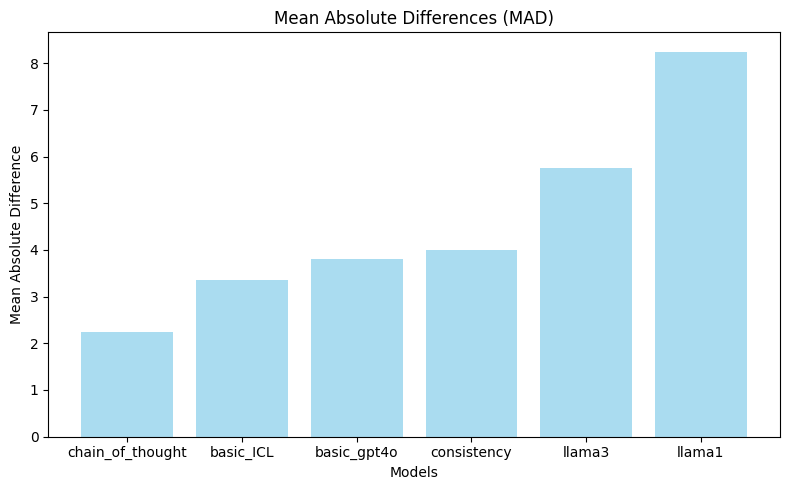

Mean Absolute Differences (MAD):
chain_of_thought: 2.25
basic_ICL: 3.35
basic_gpt4o: 3.80
consistency: 4.00
llama3: 5.75
llama1: 8.25


In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
# data = ex_Credits
data = consistency_data
print(data)
def evaluate_credits(data):
    """
    Evaluate and visualize model performance based on credit differences compared to the tutor.
    
    Parameters:
        data (dict): A dictionary where submission IDs map to credit values from the tutor and models.
    """
    models = set(next(iter(data.values())).keys()) - {'tutor'}
    diffs = {model: [] for model in models}
    
    # Calculate absolute differences
    for submission_id, credits in data.items():
        tutor_score = credits['tutor']
        for model in models:
            diffs[model].append(abs(credits[model] - tutor_score))
    
    # Calculate Mean Absolute Differences (MAD)
    mad_scores = {model: np.mean(diffs[model]) for model in models}
    
    # Sort MAD scores
    sorted_mad_scores = dict(sorted(mad_scores.items(), key=lambda x: x[1]))
    
    # Plotting the sorted bar plot of MAD scores
    plt.figure(figsize=(8, 5))
    plt.bar(sorted_mad_scores.keys(), sorted_mad_scores.values(), color='skyblue', alpha=0.7)
    plt.title("Mean Absolute Differences (MAD)")
    plt.xlabel("Models")
    plt.ylabel("Mean Absolute Difference")
    
    plt.tight_layout()
    plt.show()
    
    # Print sorted insights
    print("Mean Absolute Differences (MAD):")
    for model, mad in sorted_mad_scores.items():
        print(f"{model}: {mad:.2f}")

# Run evaluation
evaluate_credits(data)


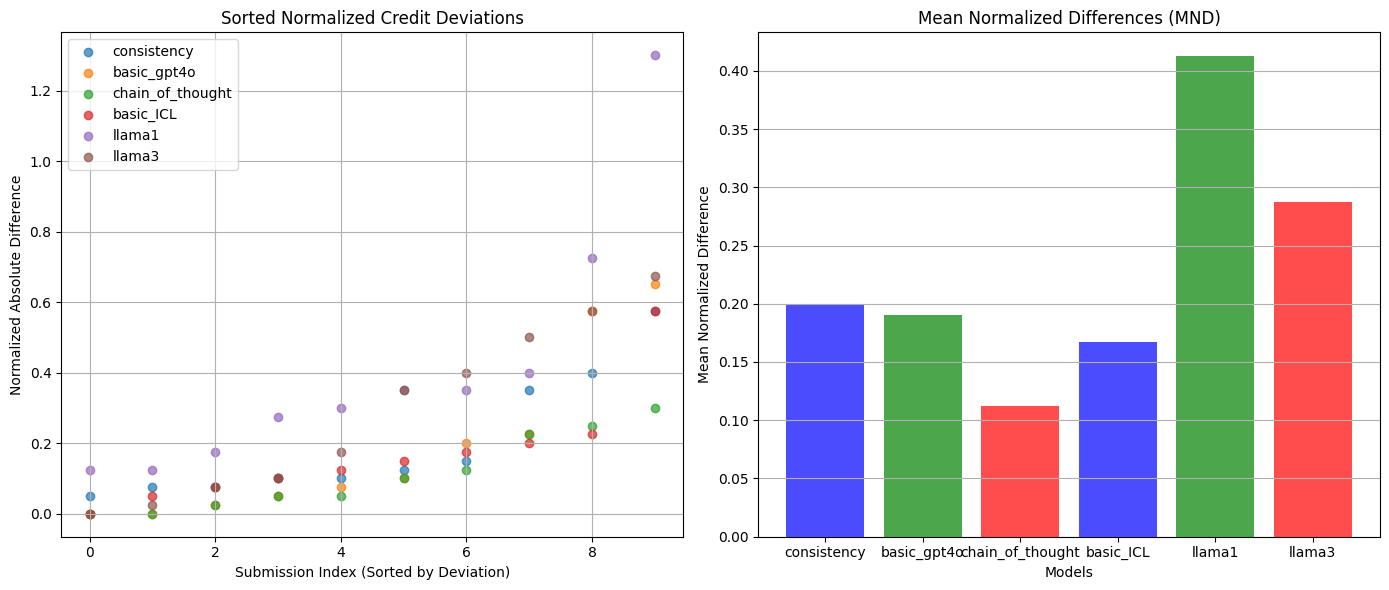

Mean Normalized Differences (MND):
chain_of_thought: 0.11
basic_ICL: 0.17
basic_gpt4o: 0.19
consistency: 0.20
llama3: 0.29
llama1: 0.41


In [45]:
def evaluate_credits_with_normalization_improved(data):
    """
    Evaluate and visualize model performance based on normalized credit differences compared to the tutor.
    
    Parameters:
        data (dict): A dictionary where submission IDs map to credit values and max credit.
    """
    models = set(next(iter(data.values())).keys()) - {'tutor', 'max_credit'}
    normalized_diffs = {model: [] for model in models}
    
    # Calculate normalized differences
    for submission_id, credits in data.items():
        tutor_score = credits['tutor']
        # max_credit = 6
        for model in models:
            deviation = abs(credits[model] - tutor_score) / max_credit
            normalized_diffs[model].append((submission_id, deviation))
    
    # Prepare data for plotting
    sorted_diffs = {
        model: sorted(deviations, key=lambda x: x[1]) for model, deviations in normalized_diffs.items()
    }
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Scatter plot of normalized deviations
    for model, deviations in sorted_diffs.items():
        indices = range(len(deviations))
        values = [d[1] for d in deviations]
        ax[0].scatter(indices, values, label=model, alpha=0.7)
    
    ax[0].set_title("Sorted Normalized Credit Deviations")
    ax[0].set_xlabel("Submission Index (Sorted by Deviation)")
    ax[0].set_ylabel("Normalized Absolute Difference")
    ax[0].legend()
    ax[0].grid()

    # Mean Normalized Differences (MND)
    mnd_scores = {model: np.mean([d[1] for d in deviations]) for model, deviations in sorted_diffs.items()}

    # Bar plot of MND scores
    ax[1].bar(mnd_scores.keys(), mnd_scores.values(), color=['blue', 'green', 'red'], alpha=0.7)
    ax[1].set_title("Mean Normalized Differences (MND)")
    ax[1].set_xlabel("Models")
    ax[1].set_ylabel("Mean Normalized Difference")
    ax[1].grid(axis='y')

    plt.tight_layout()
    plt.show()
    
    # Print insights
# Sort the dictionary by MND scores
    sorted_mnd = sorted(mnd_scores.items(), key=lambda x: x[1])

    # Print sorted MND scores
    print("Mean Normalized Differences (MND):")
    for model, mnd in sorted_mnd:
        print(f"{model}: {mnd:.2f}")

# Run the improved evaluation
evaluate_credits_with_normalization_improved(consistency_data) #ex_Credits

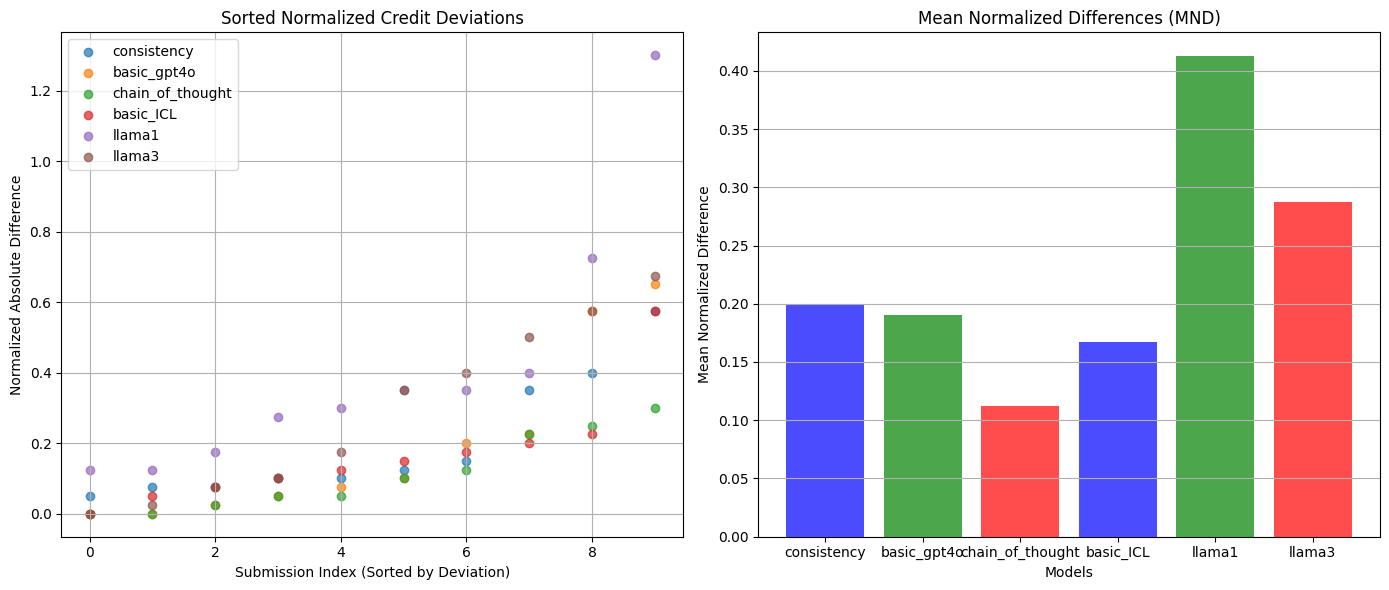

Mean Normalized Differences (MND):
chain_of_thought: 0.11
basic_ICL: 0.17
basic_gpt4o: 0.19
consistency: 0.20
llama3: 0.29
llama1: 0.41


In [46]:
def evaluate_credits_with_normalization_improved(data):
    """
    Evaluate and visualize model performance based on normalized credit differences compared to the tutor.
    
    Parameters:
        data (dict): A dictionary where submission IDs map to credit values and max credit.
    """
    models = set(next(iter(data.values())).keys()) - {'tutor', 'max_credit'}
    normalized_diffs = {model: [] for model in models}
    
    # Calculate normalized differences
    for submission_id, credits in data.items():
        tutor_score = credits['tutor']
        # max_credit = 6
        for model in models:
            deviation = abs(credits[model] - tutor_score) / max_credit
            normalized_diffs[model].append((submission_id, deviation))
    
    # Prepare data for plotting
    sorted_diffs = {
        model: sorted(deviations, key=lambda x: x[1]) for model, deviations in normalized_diffs.items()
    }
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Scatter plot of normalized deviations
    for model, deviations in sorted_diffs.items():
        indices = range(len(deviations))
        values = [d[1] for d in deviations]
        ax[0].scatter(indices, values, label=model, alpha=0.7)
    
    ax[0].set_title("Sorted Normalized Credit Deviations")
    ax[0].set_xlabel("Submission Index (Sorted by Deviation)")
    ax[0].set_ylabel("Normalized Absolute Difference")
    ax[0].legend()
    ax[0].grid()

    # Mean Normalized Differences (MND)
    mnd_scores = {model: np.mean([d[1] for d in deviations]) for model, deviations in sorted_diffs.items()}

    # Bar plot of MND scores
    ax[1].bar(mnd_scores.keys(), mnd_scores.values(), color=['blue', 'green', 'red'], alpha=0.7)
    ax[1].set_title("Mean Normalized Differences (MND)")
    ax[1].set_xlabel("Models")
    ax[1].set_ylabel("Mean Normalized Difference")
    ax[1].grid(axis='y')

    plt.tight_layout()
    plt.show()
    
    # Print insights
# Sort the dictionary by MND scores
    sorted_mnd = sorted(mnd_scores.items(), key=lambda x: x[1])

    # Print sorted MND scores
    print("Mean Normalized Differences (MND):")
    for model, mnd in sorted_mnd:
        print(f"{model}: {mnd:.2f}")

# Run the improved evaluation
evaluate_credits_with_normalization_improved(consistency_data) #ex_Credits

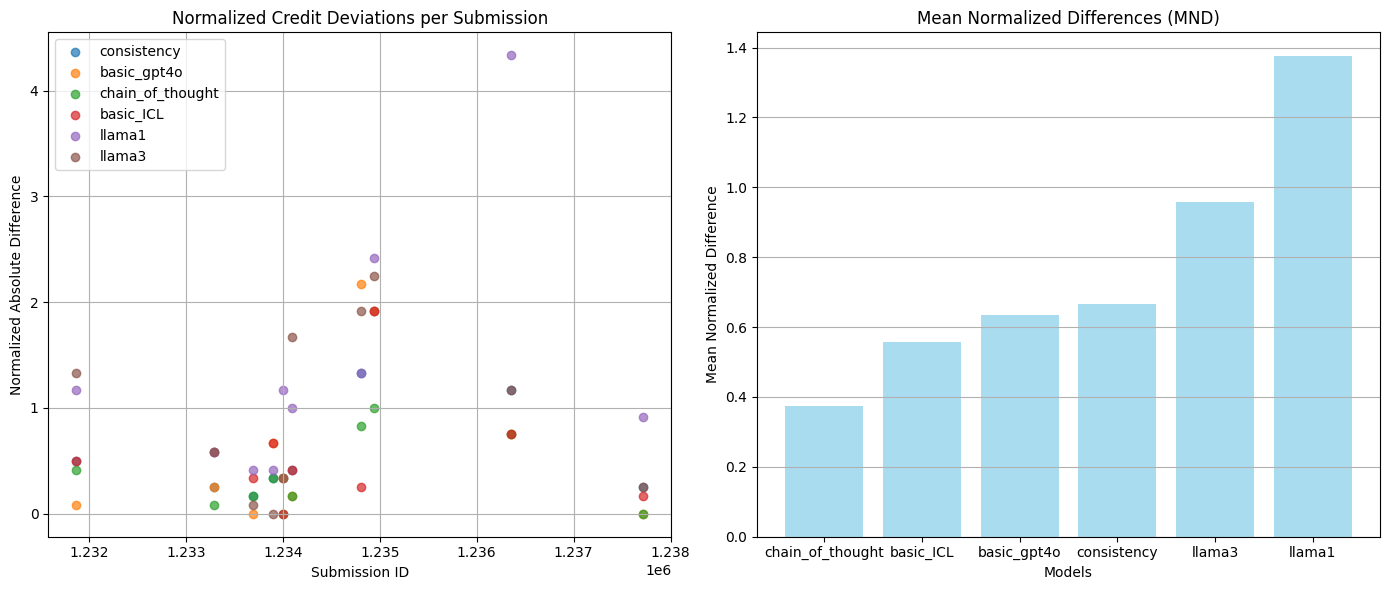

Mean Normalized Differences (MND):
chain_of_thought: 0.38
basic_ICL: 0.56
basic_gpt4o: 0.63
consistency: 0.67
llama3: 0.96
llama1: 1.38


In [47]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_credits_with_normalization_improved(data, max_credit=6):
    """
    Evaluate and visualize model performance based on normalized credit differences compared to the tutor.
    
    Parameters:
        data (dict): A dictionary where submission IDs map to credit values and max credit.
        max_credit (int): The maximum credit value to normalize the differences.
    """
    models = set(next(iter(data.values())).keys()) - {'tutor', 'max_credit'}
    normalized_diffs = {model: [] for model in models}
    
    # Calculate normalized differences
    for submission_id, credits in data.items():
        tutor_score = credits['tutor']
        for model in models:
            deviation = abs(credits[model] - tutor_score) / max_credit
            normalized_diffs[model].append((submission_id, deviation))
    
    # Prepare data for plotting
    sorted_diffs = {
        model: sorted(deviations, key=lambda x: x[1]) for model, deviations in normalized_diffs.items()
    }
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Scatter plot of normalized deviations with exact submission IDs
    for model, deviations in sorted_diffs.items():
        submission_ids = [d[0] for d in deviations]
        values = [d[1] for d in deviations]
        ax[0].scatter(submission_ids, values, label=model, alpha=0.7)
    
    ax[0].set_title("Normalized Credit Deviations per Submission")
    ax[0].set_xlabel("Submission ID")
    ax[0].set_ylabel("Normalized Absolute Difference")
    ax[0].legend()
    ax[0].grid()

    # Mean Normalized Differences (MND)
    mnd_scores = {model: np.mean([d[1] for d in deviations]) for model, deviations in sorted_diffs.items()}

    # Sort MND scores
    sorted_mnd_scores = dict(sorted(mnd_scores.items(), key=lambda x: x[1]))

    # Bar plot of MND scores
    ax[1].bar(sorted_mnd_scores.keys(), sorted_mnd_scores.values(), color='skyblue', alpha=0.7)
    ax[1].set_title("Mean Normalized Differences (MND)")
    ax[1].set_xlabel("Models")
    ax[1].set_ylabel("Mean Normalized Difference")
    ax[1].grid(axis='y')

    plt.tight_layout()
    plt.show()
    
    # Print sorted MND scores
    print("Mean Normalized Differences (MND):")
    for model, mnd in sorted_mnd_scores.items():
        print(f"{model}: {mnd:.2f}")

# Run the improved evaluation
evaluate_credits_with_normalization_improved(consistency_data) #ex_Credits


{'tutor', 'consistency', 'basic_gpt4o', 'chain_of_thought', 'basic_ICL', 'llama1', 'llama3'}


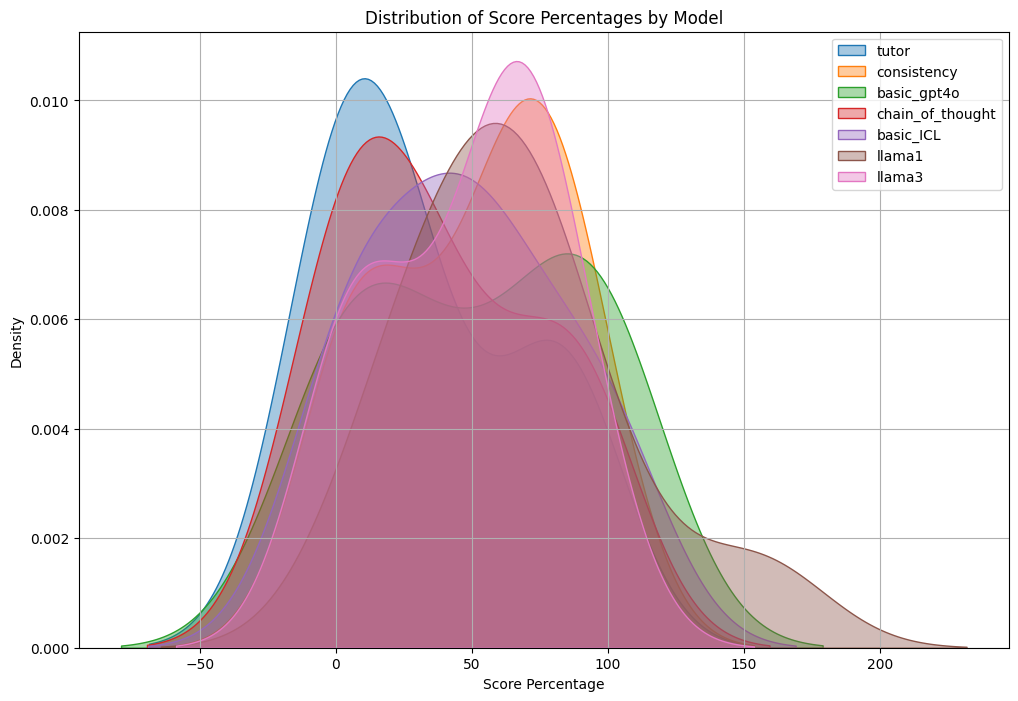

Summary Statistics:
llama1: Mean=65.75%, Std Dev=38.46%
basic_gpt4o: Mean=52.00%, Std Dev=39.53%
consistency: Mean=50.50%, Std Dev=31.91%
llama3: Mean=48.25%, Std Dev=30.64%
basic_ICL: Mean=47.25%, Std Dev=34.56%
chain_of_thought: Mean=38.75%, Std Dev=34.75%
tutor: Mean=33.00%, Std Dev=34.35%


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def plot_score_distributions(data):
    """
    Plot the distribution of scores (as percentages of total credits) for each model.
    
    Parameters:
        data (dict): A dictionary where submission IDs map to credit values and max credit.
    """
    models = set(next(iter(data.values())).keys()) - {'max_credit'}
    score_percentages = {model: [] for model in models}
    print(models)
    # Calculate score percentages
    for submission_id, credits in data.items():
        for model in models:
            percentage = (credits[model] / max_credit) * 100
            score_percentages[model].append(percentage)

    # Plot distributions
    plt.figure(figsize=(12, 8))

    for model, percentages in score_percentages.items():
        sns.kdeplot(percentages, label=model, fill=True, alpha=0.4)

    plt.title("Distribution of Score Percentages by Model")
    plt.xlabel("Score Percentage")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Insights
    print("Summary Statistics:")
    # for model, percentages in score_percentages.items():
    #     mean = np.mean(percentages)
    #     std = np.std(percentages)
    #     print(f"{model}: Mean={mean:.2f}%, Std Dev={std:.2f}%")
    statistics = []
    for model, percentages in score_percentages.items():
        mean = np.mean(percentages)
        std = np.std(percentages)
        statistics.append((model, mean, std))

    # Sort by mean (descending order)
    statistics.sort(key=lambda x: x[1], reverse=True)

    # Print sorted statistics
    for model, mean, std in statistics:
        print(f"{model}: Mean={mean:.2f}%, Std Dev={std:.2f}%")
# Example usage with data
plot_score_distributions(consistency_data) # ex_Credits